In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sc
import time
import sys
%cd /Users/James/Desktop/Eigth Semester/Stochastic Modelling/NFL_Project/Week Dependent Analysis

/Users/James/Desktop/Eigth Semester/Stochastic Modelling/NFL_Project/Week Dependent Analysis


In [2]:
# method
filesScore = ["week_data_2017.csv","week_data_2018.csv"]
filesTeams = [
              "teams_2017.csv","teams_2018.csv"]

filesPercs = ["2017_win_perc.csv","2018_win_perc.csv"]
namesCols = ["win_perc_2017","win_perc_2018"]

In [3]:
def ranking_analyzer(output,names,plot = False, threshold = 0):
    # importing necessary libraries
    from itertools import combinations
    # getting vectors from the data frame
    perc1 = np.array(output[names[0]])
    perc2 = np.array(output[names[1]])
    percscore = np.array(output['score'])
    # getting the combinations
    combs = list(combinations(np.arange(32), 2))
    ncombs = len(combs)
    # initiailizing the vectors
    scorediff = np.zeros(int(ncombs))
    wins1diff = np.zeros(int(ncombs))
    wins2diff = np.zeros(int(ncombs))
    # Computing the values
    for counter, pairs in enumerate(combs):
        scorediff[counter] = percscore[pairs[0]] - percscore[pairs[1]]
        wins1diff[counter] = perc1[pairs[0]] - perc1[pairs[1]]
        wins2diff[counter] = perc2[pairs[0]] - perc2[pairs[1]]

    # putting in a mask for plotting perspective
    mask = wins1diff < 0/16
    scorediff_not_adv = scorediff[mask]
    scorediff_adv = scorediff[np.invert(mask)]

    wins2diff_not_adv = wins2diff[mask]
    wins2diff_adv = wins2diff[np.invert(mask)]
    if plot == True:
        threshmask = scorediff_not_adv > threshold
        scoreplt = scorediff_not_adv[threshmask]
        winsplt = wins2diff_not_adv[threshmask]
        
        correctmask = winsplt > 0
        xc = scoreplt[correctmask]
        yc = winsplt[correctmask]
        xic = scoreplt[np.invert(correctmask)]
        yic = winsplt[np.invert(correctmask)]
        
        plt.figure(figsize=(15,7))
        plt.plot(scorediff_not_adv,wins2diff_not_adv,'ko',label = "Predictions Outside of Threshold")
        plt.plot(xc,yc,'go',label = "Correct Contrary Prediction")
        plt.plot(xic,yic,'ro',label = "Incorrect Contrary Prediction")
        plt.plot([0,1.01*np.max(scorediff)],[0,0],'k-')
        plt.plot([threshold,threshold],[np.min(wins2diff),np.max(wins2diff)],'k-')
        plt.xlabel('Difference in PageRank Score')
        plt.ylabel('Difference in Following Year Winning Percentage')
        plt.legend()
        plt.grid()
        
    
    # Getting the percentage of games where a team with a same or worse record in year N
    # with a better PageRank ended up being better in year N+1
    # Threshold determines amount PageRank needs to be better by
    
    mask = scorediff_not_adv > threshold
    wins2diff_not_adv = wins2diff_not_adv[mask]
    perc_upset = np.sum(wins2diff_not_adv > 0)/len(wins2diff_not_adv)
    n_upset_opps = len(wins2diff_not_adv)
    
    if plot == True:
        plt.title("Correct Percentage of Contrary Predictions: %.3f" %perc_upset)
    
    
    # Getting the total combinations right
    perc_correct_score = sum(wins2diff>0)/len(scorediff)
    perc_correct_wins = (sum(np.logical_and(wins1diff>0,wins2diff>0))+ \
                         sum(np.logical_and(wins1diff<0,wins2diff<0)))/len(wins1diff)
    
    return perc_upset, perc_correct_score,perc_correct_wins,n_upset_opps
    

In [4]:
def week_UB_Pij(data, weekub, method, weighted):
    
    # Getting the Data in the right form
    data = data.drop(['game_id', 'home_team'], axis=1)
    if method == "less":
        # IF METHOD IS WEEKS LESS THAN:
        data["week"] = data[data["week"] < weekub]["week"]
    if method == "equal":
        # IF METHOD IS GETTING THE EXACT WEEK
        data["week"] = data[data["week"] == weekub]["week"]
    if method == "between":
        # If METHOD IS BETWEEN (WITH CONTAINMENT ON THE UPPER END)
        data["week"] = data[np.logical_and(data["week"] > weekub[0],data["week"] <= weekub[1])]["week"]
    data = data.dropna()
    data = data.drop("week", axis = 1)
    data_np = np.array(data)
    
    Pij = np.zeros((32,32))
    
    # Computing the Pij Matrix
    for iCnt in range(np.shape(data_np)[0]):
        winner = int(data_np[iCnt,0])-1
        loser =  int(data_np[iCnt,1])-1
        # checking if an interdivisional game has occurred
        if (Pij[loser,winner] == 0) & (Pij[winner,loser] == 0):
            Pij[winner,loser] = data_np[iCnt,2]
        # when the other team had won the first game
        elif (Pij[loser,winner] > 0):
            if (Pij[loser,winner] > data_np[iCnt,2]):
                Pij[loser,winner] = (Pij[loser,winner] - data_np[iCnt,2])/2
            else: 
                Pij[winner,loser] = -(Pij[loser,winner] - data_np[iCnt,2])/2
                Pij[loser,winner] = 0
        # when the same team won the first game
        else: 
            Pij[winner,loser] = (Pij[winner,loser] + data_np[iCnt,2])/2
            
    if(weighted == False):
                Pij[Pij!=0] = 1
            
    # making sure none of the columns sum to 0
    if len(np.where(Pij.sum(axis = 0) == 0)[0]) > 0:
        empty_vect = np.where(Pij.sum(axis = 0) == 0)[0]
        for iCnt in range(len(empty_vect)):
            Pij[empty_vect[iCnt],empty_vect[iCnt]] = 1
    
    # making the Pij matrix
    Pij = Pij/Pij.sum(axis=0)
        
    # returning the Pij Matrix
    return Pij

In [5]:
def alpha_optimize_perc_combs_slow_learning(blocks,alphas,filesScore,filesTeams,filesPercs,namesCols,nSims = 10000,weighted = True):
    # intializing two vectors to store results
    score_perc_total = np.zeros(len(alphas))
    score_perc_S2 = np.zeros(len(alphas))
    wins_perc_total = np.zeros(len(alphas))
    wins_perc_S2 = np.zeros(len(alphas))

    indexer = 0
    
    # making a waitbar
    toolbar_width = len(alphas)
    sys.stdout.write("[%s]" % (" " * toolbar_width))
    sys.stdout.flush()
    sys.stdout.write("\b" * (toolbar_width+1))
    
    # iterating over all alphas
    for alpha_try in alphas:
        
        if(alpha_try >= .8):
            nSims_use = nSims
        else:
            nSims_use = 5000
        
        # initializing the two correlations
        mc_perc_score = 0
        mc_perc_wins = 0
        
        # intializing a vector to get each percentage (for getting a standard deviation)
        sd_vect = np.zeros(len(filesScore) - 1)
        sd_vect_wins = np.zeros(len(filesScore) - 1)
        
        # iterating over all years (we lose a year since we don't have anything 
        # to regress the 2019 data on)
        
        
        
        for year_of_data in np.arange(len(filesScore) - 1):
            
            # reading in the data
            data = pd.read_csv(filesScore[year_of_data],index_col=0)
            stats1 = pd.read_csv(filesPercs[year_of_data],index_col=0)
            stats2 = pd.read_csv(filesPercs[year_of_data + 1],index_col=0)
            # converting to a numpy array
            data2 = np.array(data)
            
            # ------------------------ SLOW LEARNING METHOD ---------------------------
            
            # making the teleporting probabilities uniform TO START
            v = np.ones(32)/32
            v = v[np.newaxis]
            v = v.T

        
            for iCnt in range(len(blocks)-1):
                # setting the weeks to look at
                weekub = [blocks[iCnt],blocks[iCnt+1]]

                # setting Pij
                Pij = week_UB_Pij(data, weekub, method = "between", weighted = weighted)
                # If we want the teleportation probabilties unifrom,
                # or based on team winning perc

                # initializing our first guess
                x0 = np.ones(32)/32
                x0 = x0[np.newaxis]
                x0 = x0.T

                # performing the simulation
                for i in range(5000):
                    x0 = alpha_try*np.dot(Pij,x0) + (1-alpha_try)*v

                v = x0 # KEY STEP: HERE WE ARE SETTING THE NEXT VERSION OF V TO OUT PREVIOUS SOLUTION!

            # --------------------------------------------------------------------
            
            x0 = np.squeeze(x0)

            # defining the team names
            teams = pd.read_csv(filesTeams[year_of_data],index_col=0)
            team_names = np.array(teams["team_name"])
            
            # ordering the team's by their score
            mask = np.argsort(np.squeeze(x0))[::-1]
            x0_df = np.squeeze(x0[mask])
            team_names_df = team_names[mask]
            
            # forming a data frame
            teamrank = {'Team': team_names_df, 'score': x0_df, 'wins': 32*16/2*x0_df}
            teamrank_df = pd.DataFrame(data=teamrank)
            
            output = pd.merge(teamrank_df,
                  stats1,
                  left_on = "Team",
                  right_on = "team",
                  how = "inner")

            output = pd.merge(output,
                  stats2,
                  left_on = "Team",
                  right_on = "team",
                  how = "inner")
            
            # Figuring out ranks
            names = [namesCols[year_of_data],namesCols[year_of_data+1]]
            pu, ps, pw, opps = ranking_analyzer(output,names)
            
            # Storing the results
            mc_perc_score += ps
            sd_vect[year_of_data] = ps
            mc_perc_wins += pw
            sd_vect_wins[year_of_data] = pw
            
        # Updating the percentages
        score_perc_total[indexer] = mc_perc_score/(len(filesScore) - 1)
        score_perc_S2[indexer] = np.std(sd_vect)/np.sqrt(len(filesScore) - 1)
        wins_perc_total[indexer] = mc_perc_wins/(len(filesScore) - 1)
        wins_perc_S2[indexer] = np.std(sd_vect_wins)/np.sqrt(len(filesScore) - 1)
        indexer += 1
        sys.stdout.write("-")
        sys.stdout.flush()
        
    sys.stdout.write("\n")
    return score_perc_total,score_perc_S2,wins_perc_total,wins_perc_S2

In [25]:
blocks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
alphas = np.linspace(.01,.8,30)

In [26]:
sp1, ss1, wp1, ws1 = alpha_optimize_perc_combs_slow_learning(blocks,alphas \
                                                             ,filesScore,filesTeams,filesPercs,namesCols)

[                              ------------------------------


In [33]:
sp2, ss2, wp2, ws2 = alpha_optimize_perc_combs_slow_learning(blocks,alphas \
                                                             ,filesScore,filesTeams,filesPercs,namesCols, weighted =False)

[                              ------------------------------


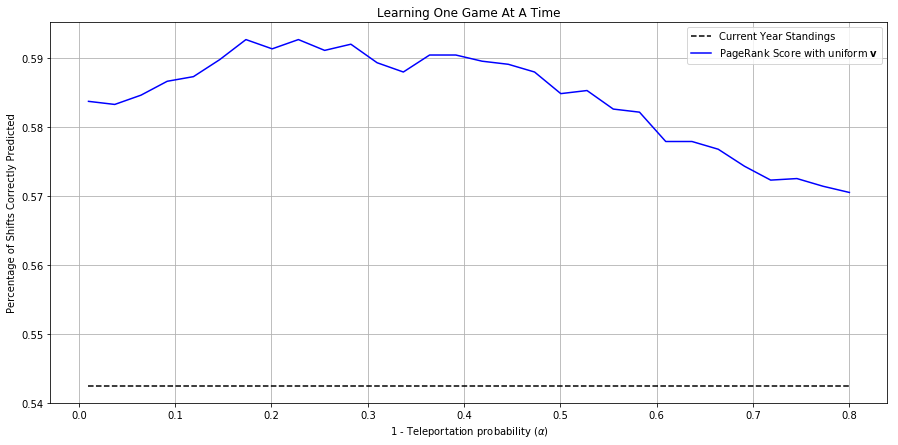

In [35]:
plt.figure(figsize=(15,7))

plt.plot(alphas,wp1,'k--',label = r'Current Year Standings')
plt.plot(alphas,sp1,'b-',label = r'PageRank Score with uniform $\bf{v}$')
plt.xlabel(r'1 - Teleportation probability ($\alpha$)')
plt.ylabel("Percentage of Shifts Correctly Predicted")
plt.title('Learning One Game At A Time')
plt.legend()
plt.grid()
plt.show()

In [36]:
blocks = [0,2,4,6,8,10,12,14,16]
alphas = np.linspace(.01,.8,30)

In [37]:
sp3, ss3, wp3, ws3 = alpha_optimize_perc_combs_slow_learning(blocks,alphas \
                                                             ,filesScore,filesTeams,filesPercs,namesCols)

[                              ------------------------------


In [38]:
sp4, ss4, wp4, ws4 = alpha_optimize_perc_combs_slow_learning(blocks,alphas \
                                                             ,filesScore,filesTeams,filesPercs,namesCols, weighted = False)

[                              ------------------------------


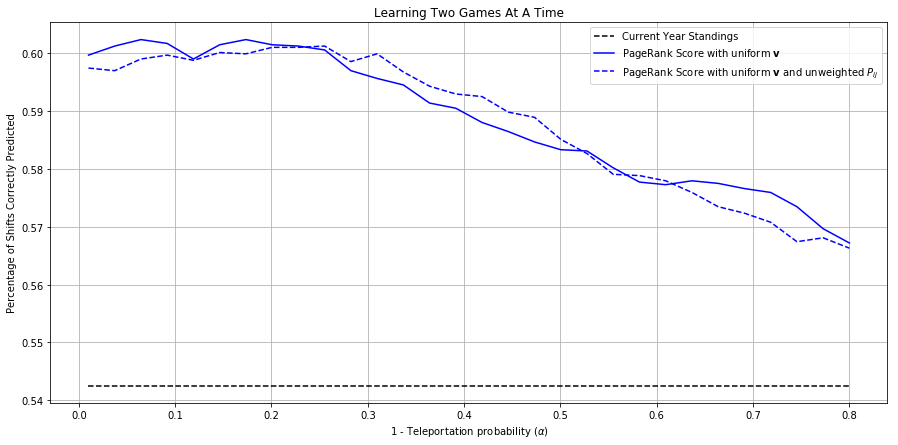

In [39]:
plt.figure(figsize=(15,7))

plt.plot(alphas,wp1,'k--',label = r'Current Year Standings')
plt.plot(alphas,sp3,'b-',label = r'PageRank Score with uniform $\bf{v}$')
plt.plot(alphas,sp4,'b--',label = r'PageRank Score with uniform $\bf{v}$ and unweighted $P_{ij}$')
plt.xlabel(r'1 - Teleportation probability ($\alpha$)')
plt.ylabel("Percentage of Shifts Correctly Predicted")
plt.title('Learning Two Games At A Time')
plt.legend()
plt.grid()
plt.show()

In [40]:
blocks = [0,2,4,6,8,10,12,14,16]
alphas = np.linspace(.01,.3,30)

In [41]:
sp5, ss5, wp5, ws5 = alpha_optimize_perc_combs_slow_learning(blocks,alphas \
                                                             ,filesScore,filesTeams,filesPercs,namesCols)

[                              ------------------------------


In [42]:
sp6, ss6, wp6, ws6 = alpha_optimize_perc_combs_slow_learning(blocks,alphas \
                                                             ,filesScore,filesTeams,filesPercs,namesCols, weighted = False)

[                              ------------------------------


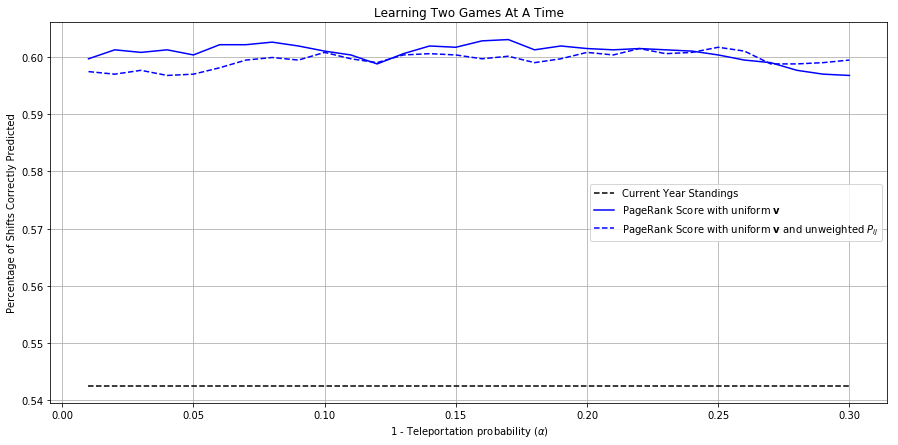

In [43]:
plt.figure(figsize=(15,7))

plt.plot(alphas,wp1,'k--',label = r'Current Year Standings')
plt.plot(alphas,sp5,'b-',label = r'PageRank Score with uniform $\bf{v}$')
plt.plot(alphas,sp6,'b--',label = r'PageRank Score with uniform $\bf{v}$ and unweighted $P_{ij}$')
plt.xlabel(r'1 - Teleportation probability ($\alpha$)')
plt.ylabel("Percentage of Shifts Correctly Predicted")
plt.title('Learning Two Games At A Time')
plt.legend()
plt.grid()
plt.show()

In [6]:
blocks = [0,3,6,9,12,16]
alphas = np.linspace(.01,.8,30)

In [7]:
sp7, ss7, wp7, ws7 = alpha_optimize_perc_combs_slow_learning(blocks,alphas \
                                                             ,filesScore,filesTeams,filesPercs,namesCols)

[                              ------------------------------


In [8]:
sp8, ss8, wp8, ws8 = alpha_optimize_perc_combs_slow_learning(blocks,alphas \
                                                             ,filesScore,filesTeams,filesPercs,namesCols, weighted = False)

[                              ------------------------------


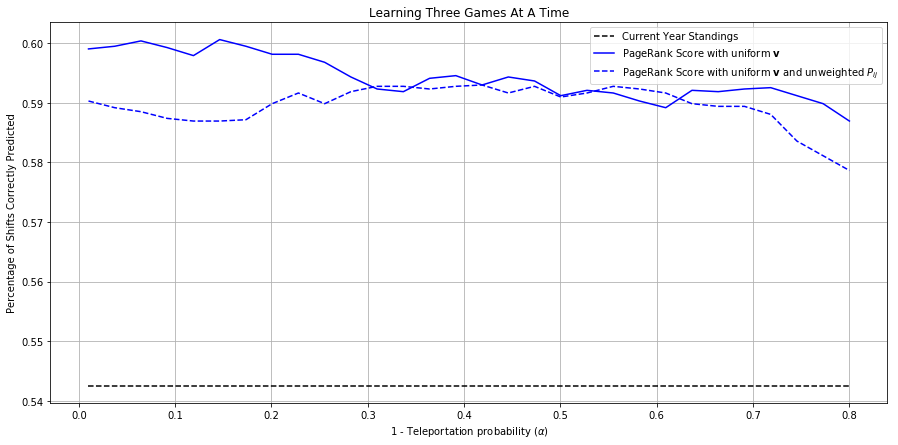

In [10]:
plt.figure(figsize=(15,7))

plt.plot(alphas,wp7,'k--',label = r'Current Year Standings')
plt.plot(alphas,sp7,'b-',label = r'PageRank Score with uniform $\bf{v}$')
plt.plot(alphas,sp8,'b--',label = r'PageRank Score with uniform $\bf{v}$ and unweighted $P_{ij}$')
plt.xlabel(r'1 - Teleportation probability ($\alpha$)')
plt.ylabel("Percentage of Shifts Correctly Predicted")
plt.title('Learning Three Games At A Time')
plt.legend()
plt.grid()
plt.show()

In [52]:
blocks = [0,4,8,12,17]
alphas = np.linspace(.01,.3,30)

In [53]:
sp9, ss9, wp9, ws9 = alpha_optimize_perc_combs_slow_learning(blocks,alphas \
                                                             ,filesScore,filesTeams,filesPercs,namesCols)

[                              ------------------------------


In [54]:
sp10, ss10, wp10, ws10 = alpha_optimize_perc_combs_slow_learning(blocks,alphas \
                                                             ,filesScore,filesTeams,filesPercs,namesCols, weighted = False)

[                              ------------------------------


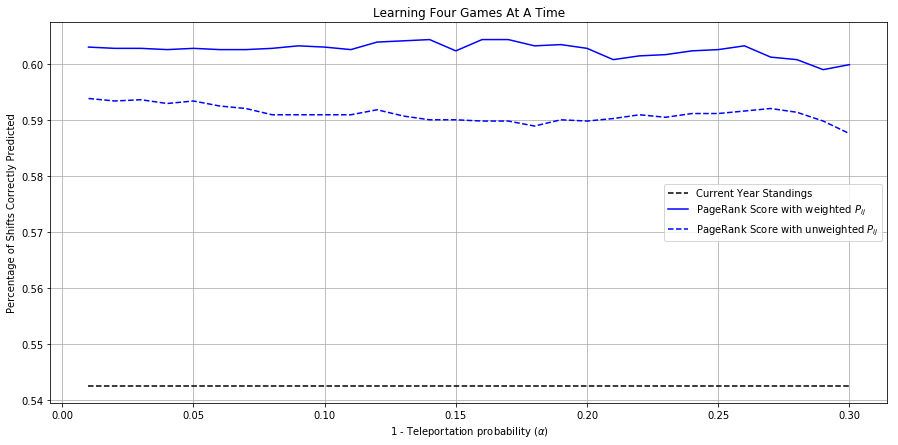

In [56]:
plt.figure(figsize=(15,7))

plt.plot(alphas,wp1,'k--',label = r'Current Year Standings')
plt.plot(alphas,sp9,'b-',label = r'PageRank Score with weighted $P_{ij}$')
plt.plot(alphas,sp10,'b--',label = r'PageRank Score with unweighted $P_{ij}$')
plt.xlabel(r'1 - Teleportation probability ($\alpha$)')
plt.ylabel("Percentage of Shifts Correctly Predicted")
plt.title('Learning Four Games At A Time')
plt.legend()
plt.grid()
plt.show()

In [18]:
blocks = [0,4,8,12,16]
alphas = [.05,.06]

In [19]:
sp20, ss20, wp20, ws20 = alpha_optimize_perc_combs_slow_learning(blocks,alphas \
                                                             ,filesScore,filesTeams,filesPercs,namesCols)

[  --


In [20]:
print(sp20)

[ 0.64516129  0.64516129]


In [109]:
sp21, ss21, wp21, ws21 = alpha_optimize_perc_combs_slow_learning(blocks,alphas \
                                                             ,filesScore,filesTeams,filesPercs,namesCols, weighted = False)

[                                                            ------------------------------------------------------------


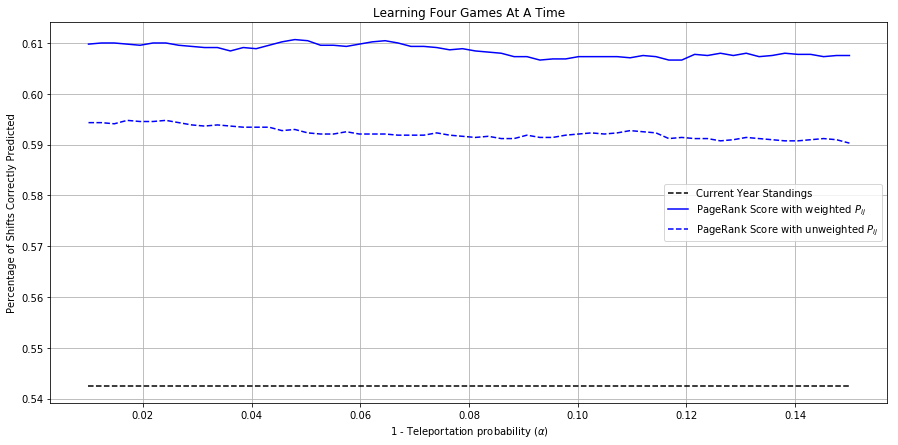

In [111]:
plt.figure(figsize=(15,7))

plt.plot(alphas,wp20,'k--',label = r'Current Year Standings')
plt.plot(alphas,sp20,'b-',label = r'PageRank Score with weighted $P_{ij}$')
plt.plot(alphas,sp21,'b--',label = r'PageRank Score with unweighted $P_{ij}$')
plt.xlabel(r'1 - Teleportation probability ($\alpha$)')
plt.ylabel("Percentage of Shifts Correctly Predicted")
plt.title('Learning Four Games At A Time')
plt.legend()
plt.grid()
plt.show()

In [82]:
np.max(sp20)*100

60.506272401433705

# Learning 3 Times a Season

In [83]:
blocks = [0,5,11,17]
alphas = np.linspace(.01,.6,30)

In [59]:
sp11, ss11, wp11, ws11 = alpha_optimize_perc_combs_slow_learning(blocks,alphas \
                                                             ,filesScore,filesTeams,filesPercs,namesCols)

[                              ------------------------------


In [60]:
sp12, ss12, wp12, ws12 = alpha_optimize_perc_combs_slow_learning(blocks,alphas \
                                                             ,filesScore,filesTeams,filesPercs,namesCols, weighted = False)

[                              ------------------------------


ValueError: x and y must have same first dimension, but have shapes (60,) and (30,)

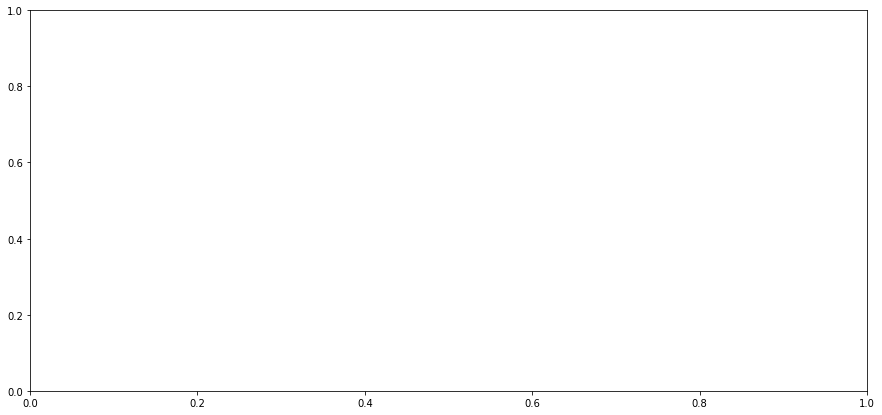

In [110]:
plt.figure(figsize=(15,7))

plt.plot(alphas,wp1,'k--',label = r'Current Year Standings')
plt.plot(alphas,sp11,'b-',label = r'PageRank Score with weighted $P_{ij}$')
plt.plot(alphas,sp12,'b--',label = r'PageRank Score with unweighted $P_{ij}$')
plt.xlabel(r'1 - Teleportation probability ($\alpha$)')
plt.ylabel("Percentage of Shifts Correctly Predicted")
plt.title('Learning 3 Times a Season')
plt.legend()
plt.grid()
plt.show()

In [63]:
blocks = [0,8,17]
alphas = np.linspace(.01,.6,30)

In [64]:
sp13, ss13, wp13, ws13 = alpha_optimize_perc_combs_slow_learning(blocks,alphas \
                                                             ,filesScore,filesTeams,filesPercs,namesCols)

[                              ------------------------------


In [65]:
sp14, ss14, wp14, ws14 = alpha_optimize_perc_combs_slow_learning(blocks,alphas \
                                                             ,filesScore,filesTeams,filesPercs,namesCols, weighted = False)

[                              ------------------------------


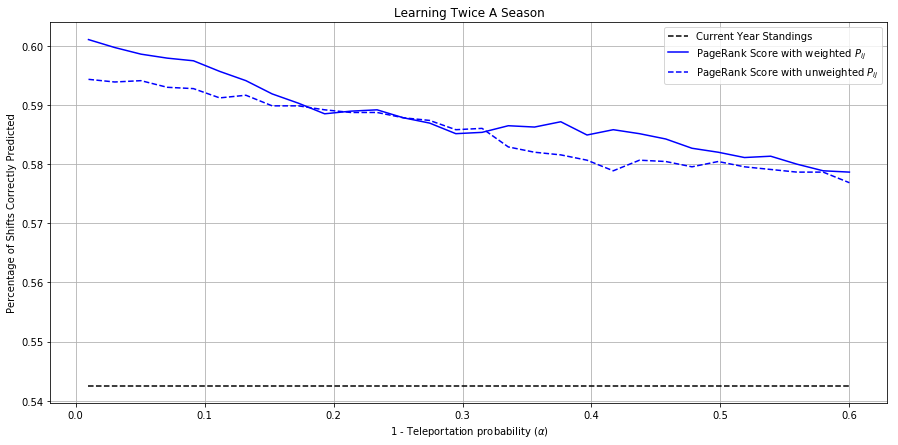

In [67]:
plt.figure(figsize=(15,7))

plt.plot(alphas,wp1,'k--',label = r'Current Year Standings')
plt.plot(alphas,sp13,'b-',label = r'PageRank Score with weighted $P_{ij}$')
plt.plot(alphas,sp14,'b--',label = r'PageRank Score with unweighted $P_{ij}$')
plt.xlabel(r'1 - Teleportation probability ($\alpha$)')
plt.ylabel("Percentage of Shifts Correctly Predicted")
plt.title('Learning Twice A Season')
plt.legend()
plt.grid()
plt.show()

In [85]:
blocks = [0,17]
alphas = np.linspace(.01,.15,60)

In [86]:
sp22, ss22, wp22, ws22 = alpha_optimize_perc_combs_slow_learning(blocks,alphas \
                                                             ,filesScore,filesTeams,filesPercs,namesCols)

[                                                            ------------------------------------------------------------


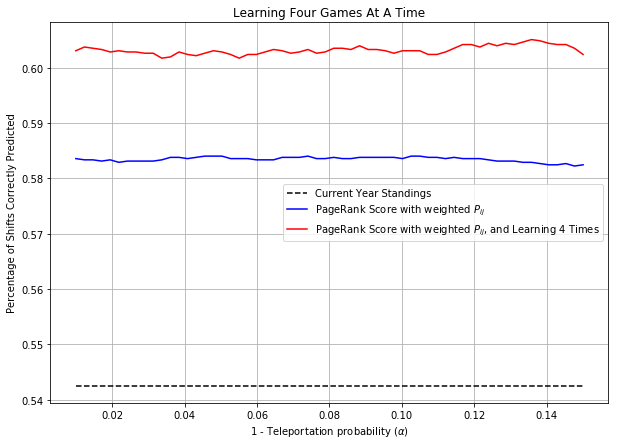

In [94]:
plt.figure(figsize=(10,7))

plt.plot(alphas,wp20,'k--',label = r'Current Year Standings')
plt.plot(alphas,sp22,'b-',label = r'PageRank Score with weighted $P_{ij}$')
plt.plot(alphas,sp20,'r-',label = r'PageRank Score with weighted $P_{ij}$, and Learning 4 Times')
plt.xlabel(r'1 - Teleportation probability ($\alpha$)')
plt.ylabel("Percentage of Shifts Correctly Predicted")
plt.title('Learning Four Games At A Time')
plt.legend()
plt.grid()
plt.show()

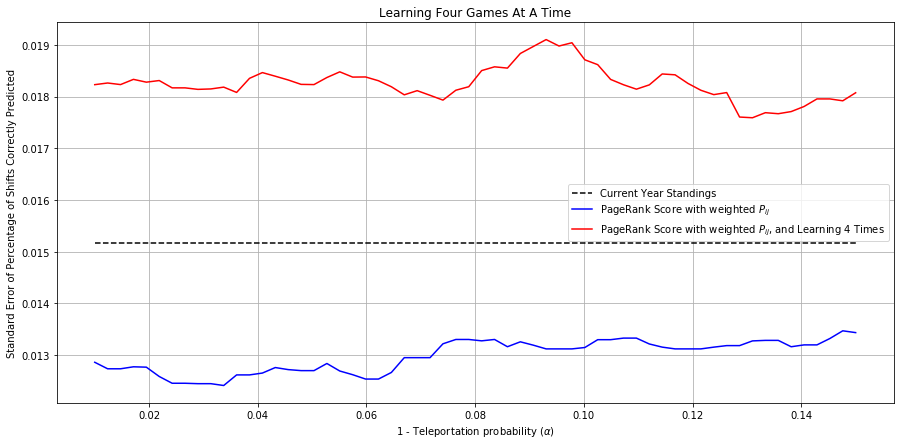

In [91]:
plt.figure(figsize=(15,7))

plt.plot(alphas,ws20,'k--',label = r'Current Year Standings')
plt.plot(alphas,ss22,'b-',label = r'PageRank Score with weighted $P_{ij}$')
plt.plot(alphas,ss20,'r-',label = r'PageRank Score with weighted $P_{ij}$, and Learning 4 Times')
plt.xlabel(r'1 - Teleportation probability ($\alpha$)')
plt.ylabel("Standard Error of Percentage of Shifts Correctly Predicted")
plt.title('Learning Four Games At A Time')
plt.legend()
plt.grid()
plt.show()

In [95]:
blocks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
alphas = np.linspace(.01,.15,60)

In [96]:
sp30, ss30, wp30, ws30 = alpha_optimize_perc_combs_slow_learning(blocks,alphas \
                                                             ,filesScore,filesTeams,filesPercs,namesCols)

[                                                            ------------------------------------------------------------


/Users/James/Desktop/Eigth Semester/Stochastic Modelling/NFL_Project


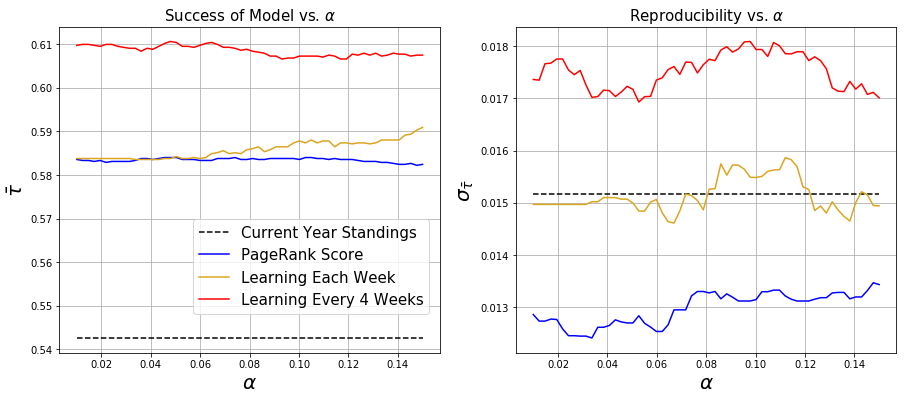

In [125]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(alphas,wp20,'k--',label = r'Current Year Standings')
plt.plot(alphas,sp22,'b-',label = r'PageRank Score',color = "blue")
plt.plot(alphas,sp30,'b-',label = r'Learning Each Week',color = "goldenrod")
plt.plot(alphas,sp20,'r-',label = r'Learning Every 4 Weeks', color = "red")
plt.grid()
plt.xlabel(r'$\alpha$',fontsize=20)
plt.ylabel(r'$\bar{\tau}$', fontsize=20)
plt.title(r'Success of Model vs. $\alpha$',fontsize=15)

plt.legend(loc = (.35,.12), prop={'size': 15})
plt.show

plt.subplot(1,2, 2)
plt.plot(alphas,ws20,'k--',label = r'Current Year Standings')
plt.plot(alphas,ss22,'b-',label = r'PageRank Score',color = "blue")
plt.plot(alphas,ss30,'b-',label = r'Learning Each Week',color = "goldenrod")
plt.plot(alphas,ss20,'r-',label = r'Learning Every 4 Weeks', color = "red")
plt.grid()
plt.xlabel(r'$\alpha$',fontsize=20)
plt.ylabel(r'$\sigma_{\bar{\tau}}$', fontsize=20)
plt.title(r'Reproducibility vs. $\alpha$',fontsize=15)
%cd /Users/James/Desktop/Eigth Semester/Stochastic Modelling/NFL_Project/
plt.savefig('biafix2.png')
plt.show()



In [114]:
np.max(sp20)

0.61066308243727607